In [1]:
from codecarbon import EmissionsTracker
import logging
output_directory = "/fp/homes01/u01/ec-krimhau/thesis_code/"

tracker = EmissionsTracker(output_dir=output_directory)
tracker.start()

[codecarbon INFO @ 07:47:29] [setup] RAM Tracking...
[codecarbon INFO @ 07:47:29] [setup] GPU Tracking...
[codecarbon INFO @ 07:47:29] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 07:47:29] [setup] CPU Tracking...
[codecarbon WARNING @ 07:47:29] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 07:47:32] We saw that you have a AMD EPYC 7642 48-Core Processor but we don't know it. Please contact us.
[codecarbon INFO @ 07:47:32] CPU Model on constant consumption mode: AMD EPYC 7642 48-Core Processor
[codecarbon INFO @ 07:47:32] >>> Tracker's metadata:
[codecarbon INFO @ 07:47:32]   Platform system: Linux-5.14.0-362.8.1.el9_3.x86_64-x86_64-with-glibc2.34
[codecarbon INFO @ 07:47:32]   Python version: 3.11.3
[codecarbon INFO @ 07:47:32]   CodeCarbon version: 2.3.4
[codecarbon INFO @ 07:47:32]   Available RAM : 256.000 GB
[codecarbon INFO @ 07:47:32]   CPU count: 24
[codecarbon INFO @ 07:47:32]   CPU model: AMD EPYC 7642 48-Core Processor
[codecarbon 

In [2]:
logging.getLogger('codecarbon').setLevel(logging.WARNING)

In [3]:
import os
import gc
import copy
import time
import random
import string
import joblib

# For data manipulation
import numpy as np
import pandas as pd

# Pytorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader

# Utils
from tqdm import tqdm
from collections import defaultdict

# Sklearn Imports
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GroupKFold, KFold

# For Transformer Models
from transformers import AutoTokenizer, AutoModel, AutoConfig, AdamW
from transformers import DataCollatorWithPadding
import datasets
# For colored terminal text
from colorama import Fore, Back, Style
b_ = Fore.BLUE
y_ = Fore.YELLOW
sr_ = Style.RESET_ALL

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

import wandb
# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [4]:
# Load .env file
%load_ext dotenv
%dotenv /fp/homes01/u01/ec-krimhau/thesis_code/.env

In [5]:
os.environ['WANDB_NOTEBOOK_NAME'] = '/fp/homes01/u01/ec-krimhau/thesis_code/jira/priority_model/highest_vs_rest/deberta/01_training/01_train_highest_vs_rest.ipynb'
# Get wandb api key from .env file
wandb_api_key = os.getenv('WANDB_API_KEY')
# Login to wandb to track results
wandb.login(key = wandb_api_key) # API key

wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find /fp/homes01/u01/ec-krimhau/thesis_code/jira/priority_model/highest_vs_rest/deberta/01_training/01_train_highest_vs_rest.ipynb.
wandb: Currently logged in as: haugerud-kristian (krimhau). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /fp/homes01/u01/ec-krimhau/.netrc


True

In [6]:
def id_generator(size=12, chars=string.ascii_lowercase + string.digits):
    return ''.join(random.SystemRandom().choice(chars) for _ in range(size))


HASH_NAME = id_generator(size=12)
print(HASH_NAME)


sryukuq6ef0m


In [7]:
CONFIG = {"seed": 42,
          "epochs": 3,
          "model_name": "microsoft/deberta-v3-base",
          "train_batch_size": 8,
          "valid_batch_size": 16,
          "max_length": 512,
          "learning_rate": 1e-5,
          "scheduler": 'CosineAnnealingLR',
          "min_lr": 1e-6,
          "T_max": 500,
          "weight_decay": 1e-6,
          "n_fold": 3,
          "n_accumulate": 1,
          "num_classes": 2,
          "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
          "hash_name": HASH_NAME,
          "_wandb_kernel": "deb",
          }

CONFIG["tokenizer"] = AutoTokenizer.from_pretrained(CONFIG['model_name'])
CONFIG['group'] = f'{HASH_NAME}-Baseline'


In [8]:
def set_seed(seed=42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed(CONFIG['seed'])

In [9]:
def train_test_split(df, train_percent=.85, seed=42):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(train_percent * m)
    train = df.iloc[perm[:train_end]]
    test = df.iloc[perm[train_end:]]
    return train, test

In [10]:
full_training_df = pd.read_csv("../../csv/highest_vs_rest_balanced_jira.csv" , index_col = 0)
full_training_df


,text_clean,label,class_original
class,,,
highest,when we do range query on simple keys it does ...,1,Highest
highest,unhandledpromiserejectionwarning unhandled pro...,1,Highest
rest,the fabricunittestdaily branch failing intermi...,0,Medium
rest,as a system operator i want to receive alerts ...,0,Medium
rest,there is no support in datasourcetransactionma...,0,Medium
...,...,...,...
rest,once i have imported a widget into the store i...,0,Low
rest,the spec defines an axiom of a ie singleton li...,0,Medium
rest,to have an history on master of all csvs setup...,0,Medium


In [11]:

# Drop NaN values and reset index of dataframe
full_training_df = full_training_df[full_training_df['text_clean'].notna()]
full_training_df = full_training_df.rename(columns={'text_clean': 'text'})
full_training_df = full_training_df.reset_index()
full_training_df.drop(columns=["class", "class_original"], inplace=True)

In [12]:
full_training_df

,text,label
0,when we do range query on simple keys it does ...,1
1,unhandledpromiserejectionwarning unhandled pro...,1
2,the fabricunittestdaily branch failing intermi...,0
3,as a system operator i want to receive alerts ...,0
4,there is no support in datasourcetransactionma...,0
...,...,...
110711,once i have imported a widget into the store i...,0
110712,the spec defines an axiom of a ie singleton li...,0
110713,to have an history on master of all csvs setup...,0
110714,there are still some changes expected to be me...,1


In [13]:
import pandas as pd
fine_tuning_df = pd.read_csv("../../csv/github_clean_rust_testset.csv")
fine_tuning_df


,text_clean,label
0,verify that backported commits are backports t...,0
1,two different versions of a crate interacting ...,0
2,ice when using impl trait with an infinity rec...,1
3,compiler error while compiling winrt trying to...,1
4,rust segmentation fault related to const gener...,1
...,...,...
1567,tracking issue for stdfs extensions rfc,1
1568,assertion failed error on trying to bench with...,1
1569,ice caused by llvm assertion assertion sgettyp...,0
1570,add a build container for the target was recen...,0


In [14]:

fine_tuning_df = fine_tuning_df.rename(columns={'text_clean': 'text'})
fine_tuning_df

,text,label
0,verify that backported commits are backports t...,0
1,two different versions of a crate interacting ...,0
2,ice when using impl trait with an infinity rec...,1
3,compiler error while compiling winrt trying to...,1
4,rust segmentation fault related to const gener...,1
...,...,...
1567,tracking issue for stdfs extensions rfc,1
1568,assertion failed error on trying to bench with...,1
1569,ice caused by llvm assertion assertion sgettyp...,0
1570,add a build container for the target was recen...,0


In [15]:
# Split the full training dataframe into training and test dataframes
# 85/15 split. Validation set will be created from the training set later.
train_full_training_df, test_full_training_df = train_test_split(full_training_df)


In [16]:
# Split the fine-tuning data frame into training and test data frames
# Where 30% of the data is used for training and 70% for testing
fine_tune_train_df , fine_tune_test_df = train_test_split(fine_tuning_df, train_percent=.30) # 30%

In [17]:
fine_tune_train_df

,text,label
1120,ice on inconsistent resolution for a macro cod...,0
810,ice not a type parameter on nightly regression...,1
1170,lint for unused unstable feature gates ive see...,0
534,revert using the syntax for try in libsyntax t...,0
514,compiler incorrectly assumes int will never be...,1
...,...,...
1090,stdcopy returns bad file descriptor with write...,1
1464,tracking issue for oncecelltry work in progres...,0
566,ice z unstableoptions without extra argument t...,0
720,suggestion to reorder generic parameters ignor...,0


In [18]:
# Concatenate the training dataframes into the final training dataframe
df = pd.concat([train_full_training_df, fine_tune_train_df], ignore_index = True)

In [19]:
df

,text,label
0,currently we are using usrshareelasticsearch a...,0
1,its been over hrs since the mirror has been up...,0
2,there has been discussion on the mailing lists...,0
3,when elytron client tries to obtain clientconf...,1
4,need to be able to release all items at once v...,1
...,...,...
94574,stdcopy returns bad file descriptor with write...,1
94575,tracking issue for oncecelltry work in progres...,0
94576,ice z unstableoptions without extra argument t...,0
94577,suggestion to reorder generic parameters ignor...,0


In [20]:
gkf = GroupKFold(n_splits=CONFIG['n_fold'])

for fold, ( _, val_) in enumerate(gkf.split(X=df, groups=df.text)):
    df.loc[val_ , "kfold"] = int(fold)
    
df["kfold"] = df["kfold"].astype(int)


In [21]:
df.groupby('kfold')['label'].value_counts()


kfold  label
0      1        15899
       0        15628
1      1        15816
       0        15710
2      0        15904
       1        15622
Name: count, dtype: int64

In [22]:
df

,text,label,kfold
0,currently we are using usrshareelasticsearch a...,0,0
1,its been over hrs since the mirror has been up...,0,0
2,there has been discussion on the mailing lists...,0,2
3,when elytron client tries to obtain clientconf...,1,0
4,need to be able to release all items at once v...,1,2
...,...,...,...
94574,stdcopy returns bad file descriptor with write...,1,1
94575,tracking issue for oncecelltry work in progres...,0,2
94576,ice z unstableoptions without extra argument t...,0,0
94577,suggestion to reorder generic parameters ignor...,0,2


In [23]:
class HP_Dataset(Dataset):
    def __init__(self, df, tokenizer, max_length):
        self.df = df
        self.max_len = max_length
        self.tokenizer = tokenizer
        self.text = df['text'].values
        self.targets = df['label'].values
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        text = self.text[index]
        inputs = self.tokenizer.encode_plus(
                        text,
                        truncation=True,
                        add_special_tokens=True,
                        max_length=self.max_len
                    )
        
        return {
            'input_ids': inputs['input_ids'],
            'attention_mask': inputs['attention_mask'],
            'target': self.targets[index]
        }

In [24]:
collate_fn = DataCollatorWithPadding(tokenizer=CONFIG['tokenizer'])


In [25]:
class MeanPooling(nn.Module):
    def __init__(self):
        super(MeanPooling, self).__init__()
        
    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = input_mask_expanded.sum(1)
        sum_mask = torch.clamp(sum_mask, min=1e-9)
        mean_embeddings = sum_embeddings / sum_mask
        return mean_embeddings

In [26]:
class HP_Model(nn.Module):
    def __init__(self, model_name):
        super(HP_Model, self).__init__()
        self.model = AutoModel.from_pretrained(model_name)
        self.config = AutoConfig.from_pretrained(model_name)
        self.drop = nn.Dropout(p=0.2)
        self.pooler = MeanPooling()
        self.fc = nn.Linear(self.config.hidden_size, CONFIG['num_classes'])
        
    def forward(self, ids, mask):        
        out = self.model(input_ids=ids,attention_mask=mask,
                         output_hidden_states=False)
        out = self.pooler(out.last_hidden_state, mask)
        out = self.drop(out)
        outputs = self.fc(out)
        return outputs

In [27]:
def criterion(outputs, labels):
    return nn.CrossEntropyLoss()(outputs, labels)

In [28]:
def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch):
    model.train()
    
    dataset_size = 0
    running_loss = 0.0
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        targets = data['target'].to(device, dtype=torch.long)
        
        batch_size = ids.size(0)

        outputs = model(ids, mask)
        
        loss = criterion(outputs, targets)
        loss = loss / CONFIG['n_accumulate']
        loss.backward()
    
        if (step + 1) % CONFIG['n_accumulate'] == 0:
            optimizer.step()

            # zero the parameter gradients
            optimizer.zero_grad()

            if scheduler is not None:
                scheduler.step()
                
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        bar.set_postfix(Epoch=epoch, Train_Loss=epoch_loss,
                        LR=optimizer.param_groups[0]['lr'])
    gc.collect()
    
    return epoch_loss

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score



In [30]:
def all_classification_report(y_true, y_pred, target_names = ['Non_HP', 'HP'], digits=4):
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, target_names = target_names, digits=4))
    
    accuracy =round(accuracy_score(y_true, y_pred),4)
    print("Accuracy =",  accuracy)
    f1score = round(f1_score(y_true, y_pred),4)
    print("F1_score =", f1score)

    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['Non_HP', 'HP'])
    ax.yaxis.set_ticklabels(['Non_HP', 'HP'])
    
    return  accuracy , f1score
    
    

In [31]:
@torch.no_grad()
def valid_one_epoch(model, dataloader, device, epoch):
    model.eval()
    dataset_size = 0
    running_loss = 0.0
    
    y_pred = []
    y_true = []
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:        
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        targets = data['target'].to(device, dtype=torch.long)
        
        batch_size = ids.size(0)

        outputs = model(ids, mask)
        
        loss = criterion(outputs, targets)
        

        predictions = torch.argmax(outputs, dim=-1).flatten().tolist()
        
        target = targets.tolist()

        y_pred.extend(predictions)
        y_true.extend(target)
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        bar.set_postfix(Epoch=epoch, Valid_Loss=epoch_loss,LR=optimizer.param_groups[0]['lr'])   
    
    
    accuracy, f1score = all_classification_report(y_true,y_pred)
    gc.collect()
    
    return epoch_loss , accuracy , f1score

In [32]:
def run_training(model, optimizer, scheduler, device, num_epochs, fold):
    # To automatically log gradients
    wandb.watch(model, log_freq=100)
    
    if torch.cuda.is_available():
        print("[INFO] Using GPU: {}\n".format(torch.cuda.get_device_name()))
    
    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch_loss = np.inf
    history = defaultdict(list)
    
    for epoch in range(1, num_epochs + 1): 
        gc.collect()
        train_epoch_loss = train_one_epoch(model, optimizer, scheduler, 
                                           dataloader=train_loader, 
                                           device=CONFIG['device'], epoch=epoch)
        
        val_epoch_loss, accuracy , f1score = valid_one_epoch(model, valid_loader, device=CONFIG['device'], 
                                         epoch=epoch)
    
        history['Train Loss'].append(train_epoch_loss)
        history['Valid Loss'].append(val_epoch_loss)
      
        history['Valid accuracy'].append(accuracy)
        history['Valid f1score'].append(f1score)



        
        # Log the metrics
        wandb.log({"Train Loss": train_epoch_loss})
        wandb.log({"Valid Loss": val_epoch_loss})
        wandb.log({"Valid Accuracy": accuracy})
        wandb.log({"Valid F1_score": f1score})


        
        # deep copy the model
        if val_epoch_loss <= best_epoch_loss:
            print(f"{b_}Validation Loss Improved ({best_epoch_loss} ---> {val_epoch_loss})")
            best_epoch_loss = val_epoch_loss
            run.summary["Best Loss"] = best_epoch_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            PATH = f"{HASH_NAME}-Loss-Fold-{fold}.bin"
            torch.save(model.state_dict(), PATH)
            # Save a model file from the current directory
            print(f"Model Saved{sr_}")
            
        print()
    
    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best Loss: {:.4f}".format(best_epoch_loss))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, history


In [33]:
def prepare_loaders(fold):
    df_train = df[df.kfold != fold].reset_index(drop=True)
    df_valid = df[df.kfold == fold].reset_index(drop=True)
    
    train_dataset = HP_Dataset(df_train, tokenizer=CONFIG['tokenizer'], max_length=CONFIG['max_length'])
    valid_dataset = HP_Dataset(df_valid, tokenizer=CONFIG['tokenizer'], max_length=CONFIG['max_length'])

    train_loader = DataLoader(train_dataset, batch_size=CONFIG['train_batch_size'], collate_fn=collate_fn, 
                              num_workers=2, shuffle=True, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, batch_size=CONFIG['valid_batch_size'], collate_fn=collate_fn,
                              num_workers=2, shuffle=False, pin_memory=True)
    
    return train_loader, valid_loader

In [34]:
def fetch_scheduler(optimizer):
    if CONFIG['scheduler'] == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=CONFIG['T_max'], 
                                                   eta_min=CONFIG['min_lr'])
    elif CONFIG['scheduler'] == 'CosineAnnealingWarmRestarts':
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=CONFIG['T_0'], 
                                                             eta_min=CONFIG['min_lr'])
    elif CONFIG['scheduler'] == None:
        return None
        
    return scheduler

====== Fold: 0 ======


[INFO] Using GPU: NVIDIA A100-PCIE-40GB



100%|██████████| 1971/1971 [04:18<00:00,  7.62it/s, Epoch=1, LR=8.8e-6, Valid_Loss=0.611]


Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.6013    0.8282    0.6968     15628
          HP     0.7316    0.4603    0.5651     15899

    accuracy                         0.6427     31527
   macro avg     0.6665    0.6442    0.6309     31527
weighted avg     0.6670    0.6427    0.6303     31527

Accuracy = 0.6427
F1_score = 0.5651
Validation Loss Improved (inf ---> 0.6113059718155796)
Model Saved



100%|██████████| 1971/1971 [04:18<00:00,  7.61it/s, Epoch=2, LR=5.84e-6, Valid_Loss=0.587]


Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.6499    0.7255    0.6856     15628
          HP     0.6954    0.6159    0.6532     15899

    accuracy                         0.6702     31527
   macro avg     0.6726    0.6707    0.6694     31527
weighted avg     0.6728    0.6702    0.6693     31527

Accuracy = 0.6702
F1_score = 0.6532
Validation Loss Improved (0.6113059718155796 ---> 0.5868132517711153)
Model Saved



100%|██████████| 1971/1971 [04:18<00:00,  7.62it/s, Epoch=3, LR=2.7e-6, Valid_Loss=0.588]


Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.6598    0.6957    0.6773     15628
          HP     0.6840    0.6475    0.6652     15899

    accuracy                         0.6714     31527
   macro avg     0.6719    0.6716    0.6713     31527
weighted avg     0.6720    0.6714    0.6712     31527

Accuracy = 0.6714
F1_score = 0.6652

Training complete in 3h 26m 8s
Best Loss: 0.5868


Train Loss,█▄▁
Valid Accuracy,▁██
Valid F1_score,▁▇█
Valid Loss,█▁▁
Best Loss,0.58681
Train Loss,0.52721
Valid Accuracy,0.6714
Valid F1_score,0.6652
Valid Loss,0.58783



====== Fold: 1 ======


[INFO] Using GPU: NVIDIA A100-PCIE-40GB



100%|██████████| 1971/1971 [04:23<00:00,  7.49it/s, Epoch=1, LR=8.8e-6, Valid_Loss=0.576]


Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.6714    0.7516    0.7092     15710
          HP     0.7200    0.6345    0.6746     15816

    accuracy                         0.6929     31526
   macro avg     0.6957    0.6931    0.6919     31526
weighted avg     0.6958    0.6929    0.6919     31526

Accuracy = 0.6929
F1_score = 0.6746
Validation Loss Improved (inf ---> 0.5763479983156983)
Model Saved



100%|██████████| 1971/1971 [04:23<00:00,  7.48it/s, Epoch=2, LR=5.84e-6, Valid_Loss=0.562]


Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.7257    0.6516    0.6867     15710
          HP     0.6858    0.7554    0.7189     15816

    accuracy                         0.7037     31526
   macro avg     0.7058    0.7035    0.7028     31526
weighted avg     0.7057    0.7037    0.7029     31526

Accuracy = 0.7037
F1_score = 0.7189
Validation Loss Improved (0.5763479983156983 ---> 0.5624712658156857)
Model Saved



100%|██████████| 1971/1971 [04:23<00:00,  7.49it/s, Epoch=3, LR=2.7e-6, Valid_Loss=0.575]


Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.7104    0.7001    0.7052     15710
          HP     0.7063    0.7165    0.7114     15816

    accuracy                         0.7083     31526
   macro avg     0.7083    0.7083    0.7083     31526
weighted avg     0.7083    0.7083    0.7083     31526

Accuracy = 0.7083
F1_score = 0.7114

Training complete in 1h 44m 46s
Best Loss: 0.5625


Train Loss,█▄▁
Valid Accuracy,▁▆█
Valid F1_score,▁█▇
Valid Loss,█▁▇
Best Loss,0.56247
Train Loss,0.5135
Valid Accuracy,0.7083
Valid F1_score,0.7114
Valid Loss,0.57534



====== Fold: 2 ======


[INFO] Using GPU: NVIDIA A100-PCIE-40GB



100%|██████████| 1971/1971 [04:22<00:00,  7.52it/s, Epoch=1, LR=8.8e-6, Valid_Loss=0.576]


Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.7161    0.6442    0.6783     15904
          HP     0.6714    0.7400    0.7040     15622

    accuracy                         0.6917     31526
   macro avg     0.6938    0.6921    0.6911     31526
weighted avg     0.6940    0.6917    0.6910     31526

Accuracy = 0.6917
F1_score = 0.704
Validation Loss Improved (inf ---> 0.5759549103759989)
Model Saved



100%|██████████| 1971/1971 [04:21<00:00,  7.52it/s, Epoch=2, LR=5.84e-6, Valid_Loss=0.562]


Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.7364    0.6393    0.6845     15904
          HP     0.6763    0.7671    0.7188     15622

    accuracy                         0.7026     31526
   macro avg     0.7064    0.7032    0.7016     31526
weighted avg     0.7066    0.7026    0.7015     31526

Accuracy = 0.7026
F1_score = 0.7188
Validation Loss Improved (0.5759549103759989 ---> 0.5616777608753544)
Model Saved



100%|██████████| 1971/1971 [04:22<00:00,  7.51it/s, Epoch=3, LR=2.7e-6, Valid_Loss=0.572]


Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.7596    0.6084    0.6756     15904
          HP     0.6685    0.8039    0.7300     15622

    accuracy                         0.7053     31526
   macro avg     0.7140    0.7062    0.7028     31526
weighted avg     0.7144    0.7053    0.7026     31526

Accuracy = 0.7053
F1_score = 0.73

Training complete in 1h 43m 48s
Best Loss: 0.5617


Train Loss,█▄▁
Valid Accuracy,▁▇█
Valid F1_score,▁▅█
Valid Loss,█▁▆
Best Loss,0.56168
Train Loss,0.51412
Valid Accuracy,0.7053
Valid F1_score,0.73
Valid Loss,0.57206


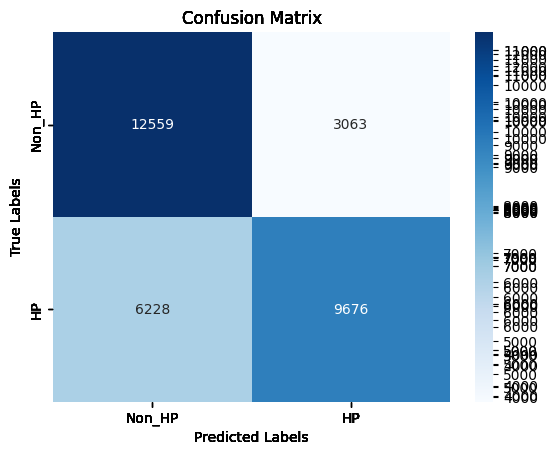

In [35]:
for fold in range(0, CONFIG['n_fold']):
    print(f"{y_}====== Fold: {fold} ======{sr_}")
    run = wandb.init(project='HP_results_Jira_High_vs_rest_results', 
                     config=CONFIG,
                     job_type='Train',
                     group=CONFIG['group'],
                     tags=[CONFIG['model_name'], f'{HASH_NAME}'],
                     name=f'{HASH_NAME}-fold-{fold}',
                     anonymous='must')
    
    # Create Dataloaders
    train_loader, valid_loader = prepare_loaders(fold=fold)
    
    model = HP_Model(CONFIG['model_name'])
    model.to(CONFIG['device'])
    
    # Define Optimizer and Scheduler
    optimizer = AdamW(model.parameters(), lr=CONFIG['learning_rate'], weight_decay=CONFIG['weight_decay'])
    scheduler = fetch_scheduler(optimizer)
    
    model, history = run_training(model, optimizer, scheduler,
                                  device=CONFIG['device'],
                                  num_epochs=CONFIG['epochs'],
                                  fold=fold)
    
    run.finish()
    
    del model, history, train_loader, valid_loader
    _ = gc.collect()
    print()

<h2> Testing Inference </h2>


In [36]:
import warnings,transformers,logging,torch

warnings.simplefilter('ignore')
logging.disable(logging.WARNING)

In [37]:
test_df = fine_tune_test_df

In [38]:
test_df

,text,label
1522,conflicting representations warning became an ...,1
834,save usedtraitimport sets to the incremental s...,0
692,segfault in and newer stable when building fir...,1
243,no variant named variantname when using selfva...,0
1424,test suite of the collection crate is failing ...,1
...,...,...
1130,implement named return value optimization in t...,0
1294,testsuiallocatornostdallocerrorhandler fail wh...,0
860,rust book refers to str primitive type as if i...,0
1459,need a bootstrapping solution for distros that...,0


In [39]:
class HP_TestDataset(Dataset):
    def __init__(self, df, tokenizer, max_length):
        self.df = df
        self.max_len = max_length
        self.tokenizer = tokenizer
        self.text = df['text'].values
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        text = self.text[index]
        inputs = self.tokenizer.encode_plus(
                        text,
                        truncation=True,
                        add_special_tokens=True,
                        max_length=self.max_len
                    )
        
        samples = {
            'input_ids': inputs['input_ids'],
            'attention_mask': inputs['attention_mask'],
            
        }

        if 'token_type_ids' in inputs:
            samples['token_type_ids'] = inputs['token_type_ids']
        
        return samples

In [40]:
collate_fn = DataCollatorWithPadding(tokenizer=CONFIG['tokenizer'])

softmax = nn.Softmax(dim=1)
model = HP_Model(CONFIG['model_name'])

In [41]:
def prepare_test_loader(test_df):    
    test_dataset = HP_TestDataset(test_df, 
                                   tokenizer=CONFIG['tokenizer'], 
                                   max_length=CONFIG['max_length'])
    
    test_loader = DataLoader(test_dataset, 
                             batch_size=CONFIG['valid_batch_size'], 
                             collate_fn=collate_fn, 
                             num_workers=2, 
                             shuffle=False, 
                             pin_memory=True, 
                             drop_last=False)
    return test_loader

test_loader = prepare_test_loader(test_df)

In [42]:
@torch.no_grad()
def inference(test_loader, model, device):
    preds = []
    preds_target = []
    model.eval()
    model.to(device)
    
    bar = tqdm(enumerate(test_loader), total=len(test_loader))
    
    for step, data in bar: 
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        
        output = model(ids, mask)
        y_preds = softmax(torch.tensor(output.to('cpu'))).numpy()
        pred_target = torch.argmax(output, dim=-1).flatten().tolist()
        
        preds.append(y_preds)
        preds_target.append(pred_target) 
    predictions = np.concatenate(preds)
    predictions_label = np.concatenate(preds_target)
    return predictions , predictions_label

In [43]:
# Change the HASH_NAME according to new generated hash for your run
#HASH_NAME = "ekgx4wmexn91"


In [44]:
deberta_predictions = []
deberta_predictions_labels = []



for fold in range(0, CONFIG['n_fold']):
    print("Fold {}".format(fold))
    
    state = torch.load(f'{HASH_NAME}-Loss-Fold-{fold}.bin')
    model.load_state_dict(state)
    
    prediction, predictions_label = inference(test_loader, model, CONFIG['device'])
    deberta_predictions.append(prediction)
    deberta_predictions_labels.append(predictions_label)
    del state, prediction; gc.collect()
    torch.cuda.empty_cache()
del model

Fold 0


100%|██████████| 69/69 [00:12<00:00,  5.52it/s]


Fold 1


100%|██████████| 69/69 [00:12<00:00,  5.56it/s]


Fold 2


100%|██████████| 69/69 [00:12<00:00,  5.56it/s]


In [45]:
deberta_predictions


[array([[0.17110145, 0.8288986 ],
        [0.6365417 , 0.36345825],
        [0.11832096, 0.881679  ],
        ...,
        [0.93377364, 0.0662263 ],
        [0.4712237 , 0.5287762 ],
        [0.35155213, 0.6484479 ]], dtype=float32),
 array([[0.18108256, 0.81891745],
        [0.42434868, 0.57565135],
        [0.2411934 , 0.75880665],
        ...,
        [0.9028932 , 0.09710682],
        [0.48242447, 0.5175755 ],
        [0.3154437 , 0.68455625]], dtype=float32),
 array([[0.16469015, 0.8353098 ],
        [0.41757494, 0.58242506],
        [0.10193142, 0.89806855],
        ...,
        [0.8769757 , 0.12302423],
        [0.6892929 , 0.31070706],
        [0.32419038, 0.6758096 ]], dtype=float32)]

In [46]:
predictions = np.mean(deberta_predictions, axis=0)
predictions

array([[0.17229138, 0.82770866],
       [0.49282178, 0.50717825],
       [0.15381525, 0.84618473],
       ...,
       [0.9045475 , 0.09545245],
       [0.54764706, 0.4523529 ],
       [0.3303954 , 0.6696046 ]], dtype=float32)

In [47]:
len(predictions)

1101

In [48]:
predictions

array([[0.17229138, 0.82770866],
       [0.49282178, 0.50717825],
       [0.15381525, 0.84618473],
       ...,
       [0.9045475 , 0.09545245],
       [0.54764706, 0.4523529 ],
       [0.3303954 , 0.6696046 ]], dtype=float32)

In [49]:
test_df["prediction_0"] = predictions[:, 0] 

In [50]:
test_df["prediction_1"] = predictions[:, 1] 

In [51]:
for i in range(0, CONFIG['n_fold']):

    test_df[f"prediction_label_fold_{i}"] = deberta_predictions_labels[i]


In [52]:
test_df

,text,label,prediction_0,prediction_1,prediction_label_fold_0,prediction_label_fold_1,prediction_label_fold_2
1522,conflicting representations warning became an ...,1,0.172291,0.827709,1,1,1
834,save usedtraitimport sets to the incremental s...,0,0.492822,0.507178,0,1,1
692,segfault in and newer stable when building fir...,1,0.153815,0.846185,1,1,1
243,no variant named variantname when using selfva...,0,0.703798,0.296202,0,0,0
1424,test suite of the collection crate is failing ...,1,0.114403,0.885597,1,1,1
...,...,...,...,...,...,...,...
1130,implement named return value optimization in t...,0,0.793489,0.206511,0,0,0
1294,testsuiallocatornostdallocerrorhandler fail wh...,0,0.408078,0.591922,1,1,1
860,rust book refers to str primitive type as if i...,0,0.904548,0.095452,0,0,0
1459,need a bootstrapping solution for distros that...,0,0.547647,0.452353,1,1,0


In [53]:
len(test_df)

1101

In [54]:
test_df['Max'] = test_df[['prediction_0','prediction_1']].idxmax(axis=1)

In [55]:
test_df["pred"] = test_df['Max'].apply(lambda x: x.replace("prediction_0", "0"))

In [56]:
test_df["pred"] = test_df['pred'].apply(lambda x: x.replace("prediction_1", "1"))


In [57]:
test_df["pred"] = test_df["pred"].astype(int)

In [58]:
test_df

,text,label,prediction_0,prediction_1,prediction_label_fold_0,prediction_label_fold_1,prediction_label_fold_2,Max,pred
1522,conflicting representations warning became an ...,1,0.172291,0.827709,1,1,1,prediction_1,1
834,save usedtraitimport sets to the incremental s...,0,0.492822,0.507178,0,1,1,prediction_1,1
692,segfault in and newer stable when building fir...,1,0.153815,0.846185,1,1,1,prediction_1,1
243,no variant named variantname when using selfva...,0,0.703798,0.296202,0,0,0,prediction_0,0
1424,test suite of the collection crate is failing ...,1,0.114403,0.885597,1,1,1,prediction_1,1
...,...,...,...,...,...,...,...,...,...
1130,implement named return value optimization in t...,0,0.793489,0.206511,0,0,0,prediction_0,0
1294,testsuiallocatornostdallocerrorhandler fail wh...,0,0.408078,0.591922,1,1,1,prediction_1,1
860,rust book refers to str primitive type as if i...,0,0.904548,0.095452,0,0,0,prediction_0,0
1459,need a bootstrapping solution for distros that...,0,0.547647,0.452353,1,1,0,prediction_0,0


In [59]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(test_df["label"].values, test_df["pred"].values)

print(cf_matrix)

[[340 228]
 [128 405]]


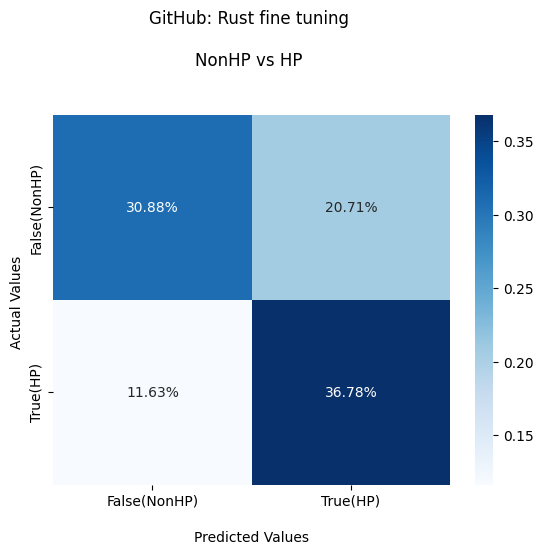

In [60]:
import seaborn as sns
import matplotlib.pyplot as plt
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('GitHub: Rust fine tuning \n\nNonHP vs HP \n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False(NonHP)','True(HP)'])
ax.yaxis.set_ticklabels(['False(NonHP)','True(HP)'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [61]:
from sklearn.metrics import classification_report


print(classification_report(test_df["label"].values, test_df["pred"].values))

              precision    recall  f1-score   support

           0       0.73      0.60      0.66       568
           1       0.64      0.76      0.69       533

    accuracy                           0.68      1101
   macro avg       0.68      0.68      0.68      1101
weighted avg       0.68      0.68      0.67      1101



In [62]:
test_df[["text","label","pred"]].to_csv("Rust_70_Test_inference.csv")

In [63]:
from sklearn.metrics import matthews_corrcoef

# Calculate the Matthew's Correlation Coefficient
mcc = matthews_corrcoef(test_df["label"].values, test_df["pred"].values)
print("Matthew's Correlation Coefficient:", mcc)

Matthew's Correlation Coefficient: 0.36235246742381144


In [64]:
tracker.stop()

0.06346369491585793